# Data Mining in Physics - Presentation 3. - DAGUR 5.4: Assessing predictive accuracy

Main goal examined in this section is how to minimize standard errors and confidence intervals of a regression model and thus increase its accuracy.

In [6]:
library(microbenchmark)
library(graphics)
library(ggplot2)

In [7]:
options(jupyter.plot_scale=1.4)

In [62]:
library(lattice)
library(DAAG)

## 1. Linear fit the `DAAG::houseprices` dataset

In [65]:
# Fit linear model on `houseprices` dataset
houseprices.lm = lm(sale.price ~ area, data=houseprices)
# Print summary
summary(houseprices.lm)


Call:
lm(formula = sale.price ~ area, data = houseprices)

Residuals:
   Min     1Q Median     3Q    Max 
-92.50 -19.30   2.41  28.02  80.61 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  70.7504    60.3477    1.17    0.262  
area          0.1878     0.0664    2.83    0.014 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 48.2 on 13 degrees of freedom
Multiple R-squared:  0.381,	Adjusted R-squared:  0.333 
F-statistic:    8 on 1 and 13 DF,  p-value: 0.0142


In [66]:
anova(houseprices.lm)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
area,1,18566,18566,8,0.0142
Residuals,13,30179,2321,NA,NA


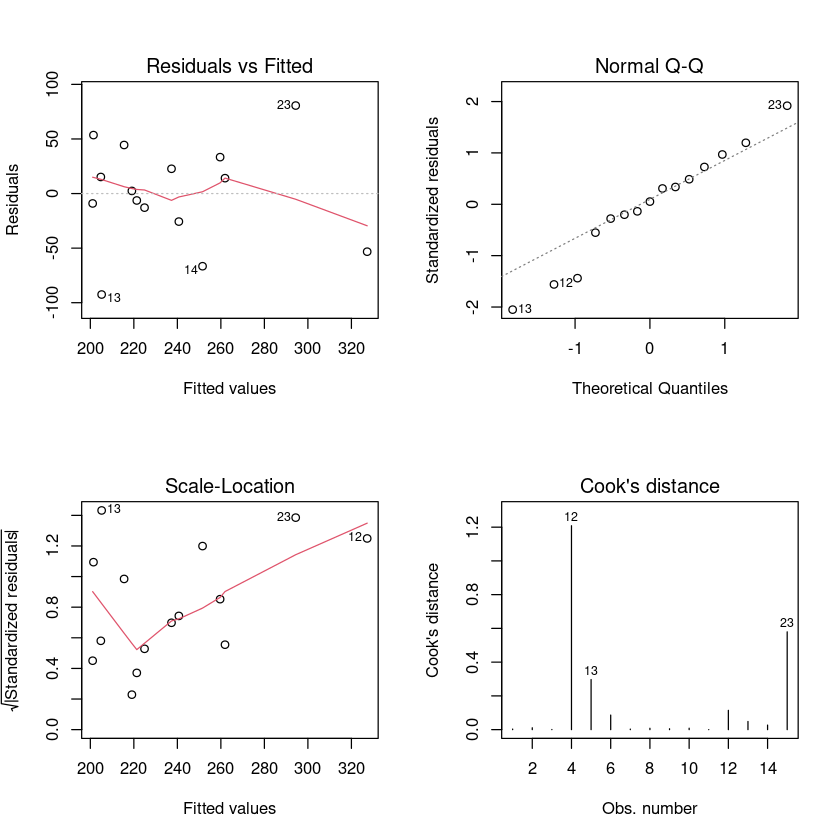

In [45]:
par(mfrow=c(2,2))

plot(houseprices.lm, which=1:4)
# By default, plots 1:3 and 5 [which=c(1:3,5)] are given
par(mfrow=c(1,1))

## 2. Plot confidence intervals

In [46]:
# Confidence interval calculations
SEb = summary(houseprices.lm)$coefficients[2, 2]
coef(houseprices.lm)[2] + qt(c(0.025, 0.975), 8)*SEb

[1] 0.0347 0.3409

In [47]:
# Obtain fitted values and standard errors (SE, then SE.OBS)
fit.with.se = predict(houseprices.lm, se.fit=TRUE)

In [48]:
# SE : Standard error
fit.with.se$se.fit

[1] 18.0 12.5 13.7 34.0 16.9 13.4 13.2 17.0 15.1 12.4 14.1 17.9 14.7 14.7 23.6

In [49]:
# SE.OBS : Precision of predicting an observation
sqrt(fit.with.se$se.fit**2+fit.with.se$residual.scale**2)

[1] 51.4 49.8 50.1 59.0 51.1 50.0 50.0 51.1 50.5 49.8 50.2 51.4 50.4 50.4 53.6

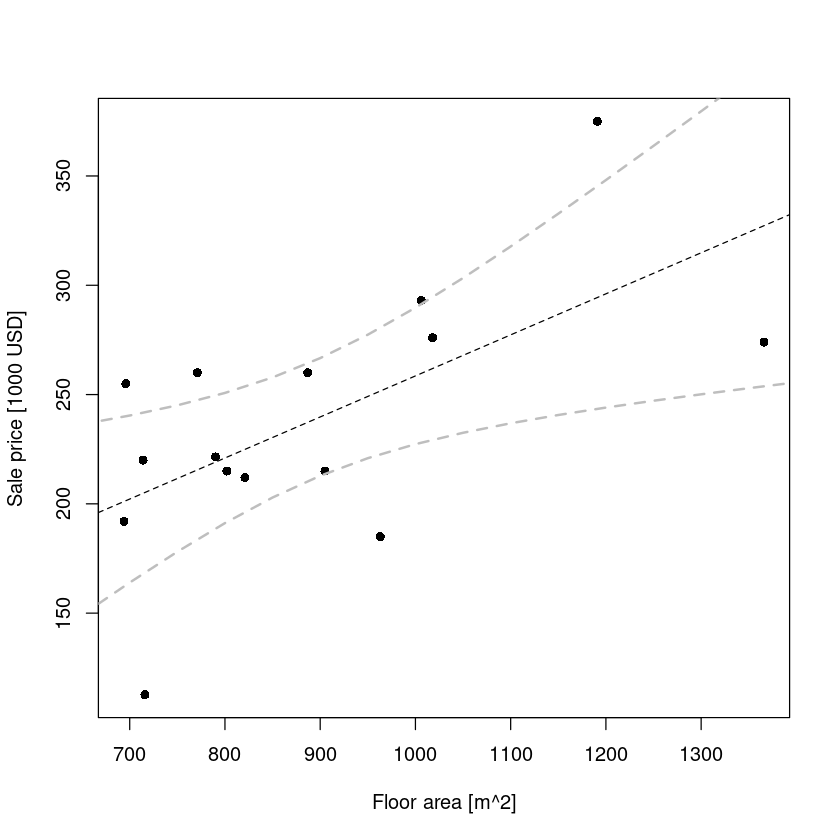

In [115]:
# Plot sale price vs floor area, with 95\% pointwise bounds for the fitted line
plot(sale.price ~ area, data=houseprices,
     xlab = "Floor area [m^2]",
     ylab = "Sale price [1000 USD]", pch = 16)

abline(houseprices.lm, lty = 2)

xy = data.frame(area = pretty(houseprices$area, 20))
yhat = predict(houseprices.lm, newdata = xy, interval="confidence")
ci = data.frame(lower=yhat[, "lwr"], upper=yhat[, "upr"])
lines(xy$area, ci$lower, lty = 2, lwd=2, col="grey")
lines(xy$area, ci$upper, lty = 2, lwd=2, col="grey")

## 3. K-fold CV on `lm()` calculations

<img src="./images/kfoldcv.png" width="1200px">

Analysis of Variance Table

Response: sale.price
          Df Sum Sq Mean Sq F value Pr(>F)  
area       1  18566   18566       8  0.014 *
Residuals 13  30179    2321                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


fold 1 
Observations in test set: 5 
               10    14    15    21     22
area        905.0 963.0 821.0 771.0 1006.0
cvpred      243.6 255.2 226.9 216.9  263.8
sale.price  215.0 185.0 212.0 260.0  293.0
CV residual -28.6 -70.2 -14.9  43.1   29.2

Sum of squares = 8684    Mean square = 1737    n = 5 

fold 2 
Observations in test set: 5 
                11   12  16     17     19
area        802.00 1366 714 1018.0 790.00
cvpred      216.81  388 190  282.5 213.16
sale.price  215.00  274 220  276.0 221.50
CV residual  -1.81 -114  30   -6.5   8.34

Sum of squares = 14083    Mean square = 2817    n = 5 

fold 3 
Observations in test set: 5 
                9   13    18    20   23
area        694.0  716 887.0 696.0 1191
cvpred      216.3 

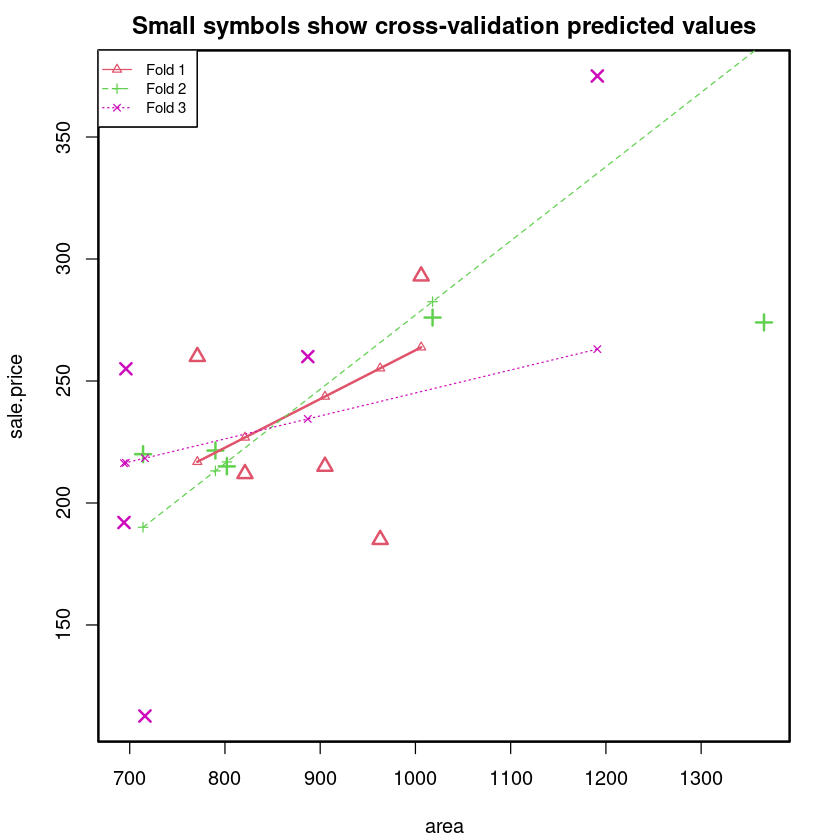

In [83]:
CVout = CVlm(houseprices, houseprices.lm, m=3, plotit=TRUE)

### Calculate error of K-fold model

The K-Fold error is even bigger, than in the naive case! Using bigger K values this can be even reversed. Eg. K=10 is a good choice for a bigger dataset.

In [82]:
# From model
summary(houseprices.lm)$sigma**2

# From K-fold CV
(8684 + 14083 + 26421) / 15

[1] 2321

[1] 3279

## 4. Bootstrapping

In [84]:
library(boot)


Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melanoma




### a.) Compute standard errors of slope

In [112]:
houseprices.fn = function (houseprices, index){

    # Randomly resample data
    house.resample = houseprices[index, ]
    # Fit linear model on the new dataset
    house.lm = lm(sale.price ~ area, data=house.resample)
    # Return the slope coefficient of the fit
    coef(house.lm)[2]
}

In [96]:
houseprices.boot = boot(houseprices, R=999, statistic=houseprices.fn)

In [97]:
houseprices.boot


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = houseprices, statistic = houseprices.fn, R = 999)


Bootstrap Statistics :
    original  bias    std. error
t1*    0.188 0.00759      0.0862

### b.) Compute confidence intervals

In [89]:
housepred.fn = function(houseprices, index){

    # Randomly resample data
    house.resample = houseprices[index, ]
    # Fit linear model on the new dataset
    house.lm = lm(sale.price ~ area, data=house.resample)
    # The last one is the bootstrapped statistics
    predict(house.lm, newdata=data.frame(area=1200))
}

In [99]:
housepred.boot = boot(houseprices, R=999, statistic=housepred.fn)

In [100]:
# 95% CI for predicted price of 1200 square foot house
boot.ci(housepred.boot, type="perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 999 bootstrap replicates

CALL : 
boot.ci(boot.out = housepred.boot, type = "perc")

Intervals : 
Level     Percentile     
95%   (243, 366 )  
Calculations and Intervals on Original Scale

### c.) Bootstrap estimates of prediction errors of house prices

In [103]:
houseprices2.fn = function (houseprices, index)
{
    house.resample = houseprices[index, ]
    house.lm = lm(sale.price ~ area, data=house.resample)
    houseprices$sale.price - predict(house.lm, houseprices) # resampled prediction
                                                            # errors
}

In [104]:
n = length(houseprices$area)
R = 200
houseprices2.boot = boot(houseprices, R=R, statistic=houseprices2.fn)
house.fac = factor(rep(1:n, rep(R, n)))

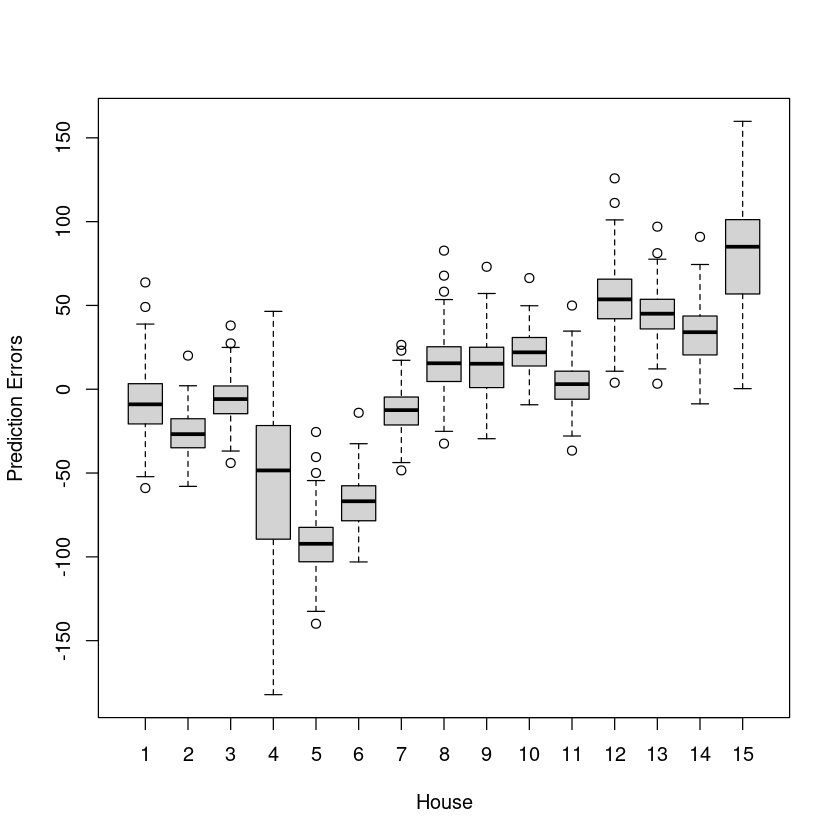

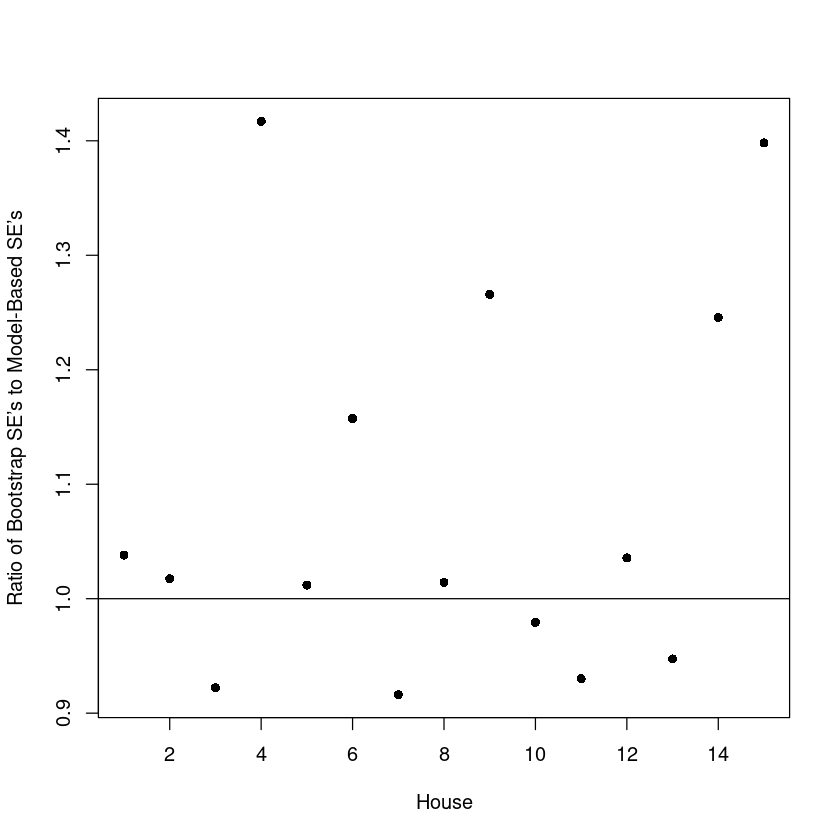

In [113]:
plot(house.fac, as.vector(houseprices2.boot$t),
     ylab="Prediction Errors",
     xlab="House")
## Ratios of bootstrap to model-based standard errors
bootse = apply(houseprices2.boot$t, 2, sd)
usualse = predict.lm(houseprices.lm, se.fit=TRUE)$se.fit
plot(bootse/usualse,
     ylab="Ratio of Bootstrap SE’s to Model-Based SE’s",
     xlab="House", pch=16)
abline(1, 0)